# Azure Machine Learning Service
## Classification on Thai-MNIST dataset with Azure AutoML
Adapted notebook from: https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/classification/auto-ml-classification.ipynb

Dataset from: https://github.com/nextwaverr/Thai-MNIST

Author: Korkrid Akepanidtaworn (Microsoft) x Pongsakorn

## 1. Import important library
- matplotlib for visualization hand-written images
- numpy and pandas for preprocessing data in an appropiate format
- tensorflow for handling dataset with idx3 format
- sklearn for evaluation metrics
- azureml.core for Azure machine learning services

In [2]:
import logging

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.contrib.learn.python.learn.datasets.mnist import extract_images, extract_labels
from sklearn.metrics import classification_report

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

## 2. Preprocess dataset
Thai-MNIST is a dataset of thai handwrite digit images which contains numbers 0-9.
So, in this section we will:
1. Download dataset and unzip
2. Assign to variables in appropiate format with function from tensorflow
3. Explore and Visualize some images

In [3]:
# Download and Unzip
# If you already downloaded the dataset, please ignore this part
# ! wget -N https://www.dropbox.com/s/jt1h7nfiiew0va4/ThaiMNIST_raw.zip
# ! unzip ThaiMNIST_raw.zip

In [4]:
# If dataset is downloaded seperately from this notebook
# Please specify path in $datasetpath below
datasetpath = ''

with open(datasetpath + 'train-images-idx3-ubyte.gz', 'rb') as f:
    x_train = extract_images(f)
with open(datasetpath + 'train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = extract_labels(f)
with open(datasetpath + 'test-images-idx3-ubyte.gz', 'rb') as f:
    x_test = extract_images(f)
with open(datasetpath + 'test-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = extract_labels(f)

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting test-images-idx3-ubyte.gz
Extracting test-labels-idx1-ubyte.gz


**Now,** we got image dataset into numpy array: X_train and X_test. Shape of the array is described as followings:

*(numbers of images, width, height, channel)*

1. ** numbers of images ** indicates total number of images, in this case for traning set is 284977

2. ** width and height ** indicate width and height of images, in this case is square image (28x28). Try to imagine that we have table with 28x28 rows and columns, each cell will be color value of the image.

3. ** channel ** indicates numbers of color channel. RGB is 3 (red, green, and blue is combined to the image) and grayscale is 1.

In [5]:
# Print shape of each array
print("Shape of training image: "+str(x_train.shape))
print("Shape of training class label: "+str(y_train.shape))
print("Shape of test image: "+str(x_test.shape))
print("Shape of test class label: "+str(y_test.shape))

Shape of training image: (284977, 28, 28, 1)
Shape of training class label: (284977,)
Shape of test image: (31659, 28, 28, 1)
Shape of test class label: (31659,)


For example, first of x_train size 28x28 is below. As I guess, it probably be a number "4".

In [6]:
pd.set_option('display.max_columns', 28)
print("Number in this figure is: "+str(y_train[0]))
pd.DataFrame(x_train[0,:,:,0])

Number in this figure is: 4


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,255,253,255,255,254,255,255,254,255,253,254,255,255,255,254,255,255,255,254,255,252,255,255,255,255,255,255,255
1,255,255,252,255,255,251,255,254,255,255,255,254,254,255,255,253,253,255,255,255,253,255,255,253,255,255,255,255
2,253,255,255,255,254,255,255,255,255,195,1,0,0,212,255,255,255,255,253,255,254,255,255,255,255,255,255,255
3,255,254,255,254,255,255,250,253,255,0,0,1,0,0,255,252,255,252,255,255,254,255,253,255,255,255,255,255
4,255,255,252,255,254,253,255,255,229,6,0,0,2,0,254,255,255,255,255,252,255,253,255,254,255,255,255,255
5,255,253,255,254,255,254,255,253,0,0,3,0,74,254,253,255,255,254,252,255,255,255,255,255,255,255,255,255
6,255,253,251,255,252,255,255,67,0,0,3,254,254,255,255,254,254,255,255,255,254,252,255,255,255,255,255,255
7,255,255,254,254,255,255,243,0,0,1,169,255,255,252,255,255,254,255,42,0,2,1,255,255,255,255,255,255
8,253,255,255,255,254,253,0,3,1,32,255,253,255,254,255,255,255,4,0,1,0,1,255,255,255,255,255,255
9,255,255,255,255,254,38,0,0,0,58,252,255,255,255,255,253,0,0,1,1,1,2,0,255,255,255,255,255


So, let's visualize some dataset

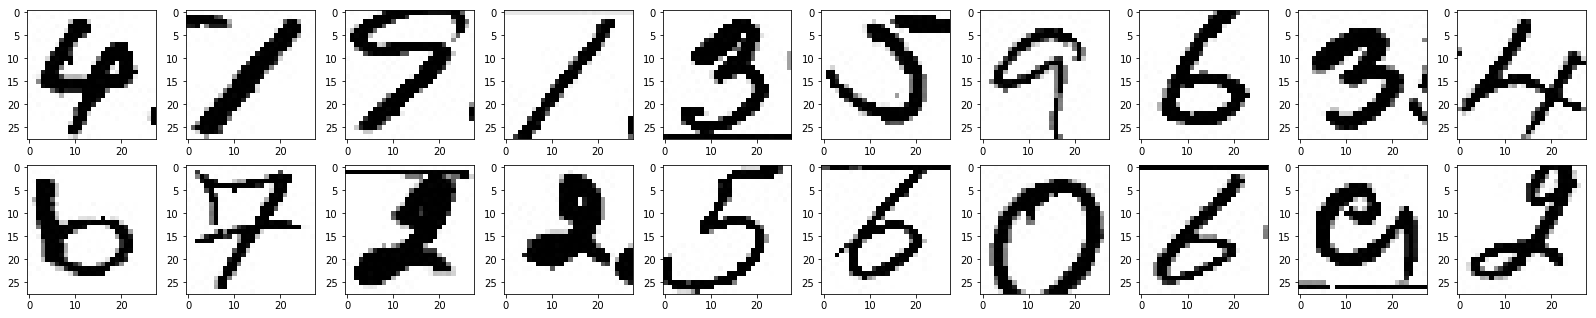

Number in these figures are: [4 1 9 1 3 5 9 6 3 4]
Number in these figures are: [6 7 2 2 5 6 0 6 9 2]


In [32]:
plt.figure(figsize=(28,28))
for i, image in enumerate(x_train[0:20]):
    plt.subplot(10,10, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()
print("Number in these figures are: "+ str(y_train[0:10]))
print("Number in these figures are: "+ str(y_train[10:20]))

Also, we can see the distribution of label class from below chart. The class is quite balance. So, we will not perform anythings to handle class-imbalanced problem.

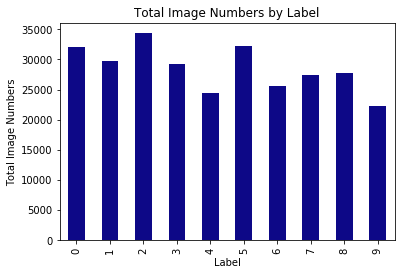

In [8]:
pd.Series(y_train).value_counts().sort_index().plot(kind="bar",colormap="plasma")
plt.xlabel("Label")
plt.ylabel("Total Image Numbers")
plt.title("Total Image Numbers by Label")
plt.show()

## 3. Automated Machine Learning with Azure

### 3.1 Setup

- As part of the setup you have already created an Azure ML `Workspace` object. It indicates path of config.json file. This file contains subscription_id, resource_group, and workspace_name for authentication in the later. 
- For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.
- After that, it will appear a link, authenticate in this link with provided code. This should be completed for connecting Azure Machine Learning Service
- If you want to see details, try to print outputDf (comment section)
- **Read more:** https://docs.microsoft.com/bs-latn-ba/azure/machine-learning/service/setup-create-workspace?view=sql-server-2016

In [9]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'auto-ml-classification-ThaiMNIST'
project_folder = './automl-local-classification'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
#outputDf = pd.DataFrame(data = output, index = [''])
#outputDf.T

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Found the config file in: /home/nbuser/library/config.json
Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FF4DJM25G to authenticate.
Interactive authentication successfully completed.


Opt-in diagnostics for better experience, quality, and security of future releases.
It just send running log to Diagnostic Monitoring. 

**Read more:** https://docs.microsoft.com/en-us/azure/azure-monitor/platform/diagnostic-logs-overview

In [10]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

Turning diagnostics collection on. 


### 3.2 Preprocess data (again) to feed into AutoML
In this section, we will preprocess data again to be fitted with AutoML model.
Moreover, we will sampling only first 1,000 to train the model for the sake of faster running time. Requirements of input data is followings:

|Property|Description|
|-|-|
|**X (training data)**|(sparse) array-like, shape = [n_samples, n_features]|
|**y (labeled class)**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers.|

So, we need to flatten the input image, (n_samples, 28x28x1) into (n_samples, 764).

In [11]:
# X_train_shape = (n_samples, width, height, channel)
X_train_shape = x_train.shape
X_train = x_train.reshape(X_train_shape[0], X_train_shape[1]*X_train_shape[2])[:1000,:]

# For labels is only 1 dimension depending on number of training images
Y_train = y_train[:1000]

X_test_shape = x_test.shape
X_test = x_test.reshape(X_test_shape[0], X_test_shape[1]*X_test_shape[2])[:1000,:]
Y_test = y_test[:1000]

Due to bias sampling only first 1,000 images, we will check imbalanced data again. This quite balance like original data.

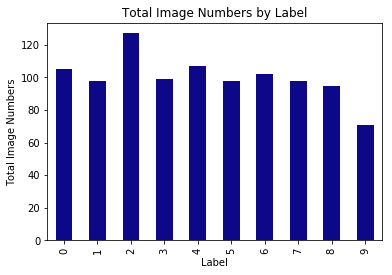

In [12]:
pd.Series(Y_train).value_counts().sort_index().plot(kind="bar",colormap="plasma")
plt.xlabel("Label")
plt.ylabel("Total Image Numbers")
plt.title("Total Image Numbers by Label")
plt.show()

### 3.3 Train the model

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**X**|training data, shape = [n_samples, n_features]|
|**y**|label of data, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. |
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|

In [13]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 5,
                             iterations = 10,
                             n_cross_validations = 5,
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = Y_train,
                             path = project_folder)

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

In [14]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_a0ee544a-6b4b-401e-8973-34505a9b1412
********************************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
SAMPLING %: Percent of the training data to sample.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
********************************************************************************************************************

 ITERATION   PIPELINE                                       SAMPLING %  DURATION      METRIC      BEST
         0   MaxAbsScaler LightGBM                          100.0000    0:01:51       0.9241    0.9241
         1   RobustScaler LightGBM                          100.0000    0:01:26       0.9432    0.9432
         2   RobustScaler LogisticRegression                100

In [15]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
auto-ml-classification-ThaiMNIST,AutoML_a0ee544a-6b4b-401e-8973-34505a9b1412,automl,Completed,Link to Azure Portal,Link to Documentation


Optionally: 
- you can continue an interrupted local run by calling `continue_experiment` without the `iterations` parameter
- or run more iterations for a completed run by specifying the `iterations` parameter. 
- In below code, it will run more 5 iterations after the above local_run running.

In [16]:
#local_run = local_run.continue_experiment(X = X_train, 
#                                          y = y_train, 
#                                          show_output = True,
#                                          iterations = 5)

### 3.4 Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [17]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…


#### Retrieve All Child Runs
You can also use SDK methods to fetch all the model runs and see individual metrics that we log. In this case, there are ten models with its metrics that we log.

In [18]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,0.92,0.94,0.81,0.94,0.89,0.94,0.93,0.91,0.91,0.94
AUC_micro,0.93,0.94,0.81,0.94,0.89,0.94,0.94,0.92,0.92,0.94
AUC_weighted,0.92,0.94,0.80,0.94,0.89,0.94,0.94,0.91,0.91,0.94
accuracy,0.65,0.70,0.52,0.67,0.60,0.68,0.68,0.61,0.63,0.71
average_precision_score_macro,0.71,0.76,0.48,0.74,0.65,0.75,0.75,0.68,0.68,0.76
average_precision_score_micro,0.72,0.77,0.46,0.75,0.65,0.76,0.76,0.68,0.68,0.77
average_precision_score_weighted,0.72,0.77,0.49,0.75,0.66,0.76,0.76,0.68,0.69,0.77
balanced_accuracy,0.65,0.69,0.52,0.67,0.60,0.68,0.68,0.61,0.63,0.70
f1_score_macro,0.64,0.69,0.51,0.67,0.59,0.68,0.67,0.60,0.62,0.70
f1_score_micro,0.65,0.70,0.52,0.67,0.60,0.68,0.68,0.61,0.63,0.71


#### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [20]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: auto-ml-classification-ThaiMNIST,
Id: AutoML_a0ee544a-6b4b-401e-8973-34505a9b1412_1,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('RobustScaler', RobustScaler(copy=True, quantile_range=[25, 75], with_centering=True,
       with_scaling=False)), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7f0e30950c50>)])


#### Best Model Based on Any Other Metric
Optionally, show the run and the model that has the smallest `log_loss` value:

In [18]:
#lookup_metric = "log_loss"
#best_run, fitted_model = local_run.get_output(metric = lookup_metric)
#print(best_run)
#print(fitted_model)

Run(Experiment: auto-ml-classification-ThaiMNIST,
Id: AutoML_4c4c3f9c-9283-4abb-a129-20d67d3602cc_1,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('RobustScaler', RobustScaler(copy=True, quantile_range=[25, 75], with_centering=True,
       with_scaling=False)), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7fbda59dab70>)])


#### Model from a Specific Iteration
Optionally, show the run and the model from the third iteration.

In [17]:
#iteration = 3
#third_run, third_model = local_run.get_output(iteration = iteration)
#print(third_run)
#print(third_model)

### 3.5 Test the model

In this section we will: 
- Calculate precision, recall, f1-score, and support of the model with test image
- Try to predict test image and see how our model works.

So, let's start with predicting the test image with our best model

In [21]:
Y_pred = fitted_model.predict(X_test)

The average precision, recall, and f1-score is around 0.72. It is better enough to run test experiment. 

There are possible ways to improve model performance, for example:
- Run with more training data.
- Use more training iteration to explore more models.

In [22]:
print("Classification Score of each labeled class")
print(classification_report(Y_test, Y_pred))

Classification Score of each labeled class
             precision    recall  f1-score   support

          0       0.80      0.92      0.86        97
          1       0.68      0.74      0.71        93
          2       0.80      0.73      0.76       124
          3       0.76      0.70      0.73        89
          4       0.61      0.66      0.63        91
          5       0.78      0.71      0.74       110
          6       0.70      0.82      0.75        92
          7       0.63      0.62      0.62       112
          8       0.75      0.73      0.74       110
          9       0.70      0.60      0.64        82

avg / total       0.72      0.72      0.72      1000



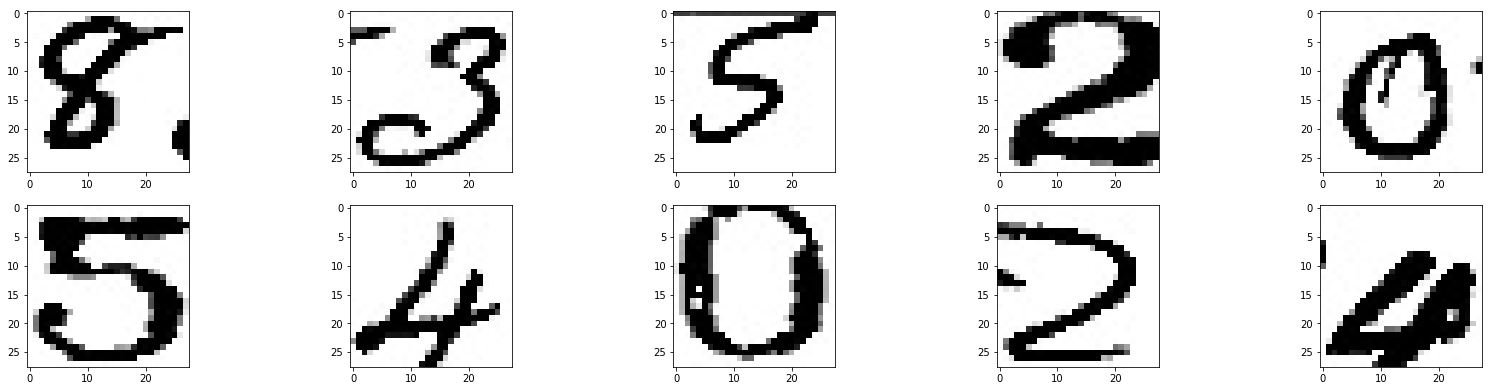

Predicted numbers in these figures are: [8, 2, 5, 2, 0] from the actual[8, 3, 5, 2, 0]
Predicted numbers in these figures are: [5, 3, 0, 3, 6] from the actual[5, 4, 0, 2, 4]


In [54]:
images = x_test[:1000,:,:].squeeze()
plt.figure(figsize=(28,28))
test_random_label = []
actual_random_label = []

for num, index in enumerate(np.random.choice(len(Y_test), 10, replace = False)):
    actual_random_label.append(Y_test[index])
    test_random_label.append(Y_pred[index])
    plt.subplot(8,5, num + 1)
    plt.imshow(images[index].squeeze(), cmap='gray')
plt.show()
print("Predicted numbers in these figures are: "+ str(test_random_label[0:5]) 
      +" from the actual"+str(actual_random_label[0:5]))
print("Predicted numbers in these figures are: "+ str(test_random_label[5:10])
      +" from the actual"+str(actual_random_label[5:10]))